This notebook plots avg coh at each pixel vs. 
1. amp dispersion
2. avg amp
3. wrap errors
4. high pass phase metric
5. disp rates

To see if there is a correlation btw coherence (which is a common masking parameter) and these criteria, which we are using for masking to see if different populations of pixels are behaving differently/show different rates. This would be sort of a proxy for how we would misinterpret the rates for different populations. 

<br> Check the conceptual part of this with Rowena.

<br> Written 6-28-23. 
***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget 

In [2]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

file_name = 'coh_avg.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
coh_avg = f1.ReadAsArray(); f1 = None
print('Avg coh values map loaded.')

file_name = 'coh_std.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
coh_std = f1.ReadAsArray(); f1 = None
print('Std of coh map loaded.')

file_name = 'amp_dispersion.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
amp_dispersion = f1.ReadAsArray(); f1 = None
print('Amplitude dispersion for each pixel loaded.')

file_name = 'avg_amp.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
avg_amp = f1.ReadAsArray(); f1 = None
print('Average amp for each pixel loaded.')

file_name = 'unfilt_unwrapped/wrap_err.i1' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
wrap_err = f1.ReadAsArray(); f1 = None
print('wrap errors for each pixel loaded.')

file_name = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/hpcor.r4' 
f1 = gdal.Open(file_name, gdal.GA_ReadOnly)
hp = f1.ReadAsArray(); f1 = None
print('high pass phase for each pixel loaded.')
# cropped area
x1 = 18000; x2 = 14000
y1 = 2100; y2 = 1000
hp_phs = hp[y2:y1,x2:x1]

Avg coh values map loaded.
Std of coh map loaded.
Amplitude dispersion for each pixel loaded.
Average amp for each pixel loaded.
wrap errors for each pixel loaded.
high pass phase for each pixel loaded.


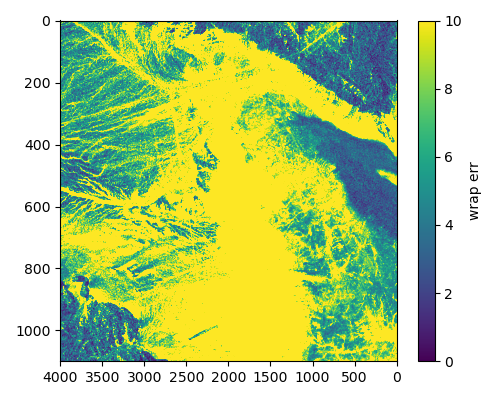

In [3]:
plt.figure(figsize=(5,4),tight_layout=True)
plt.imshow(wrap_err,cmap='viridis',aspect='auto',vmin=0,vmax=10)
plt.xlim([4000,0])
plt.colorbar(label='wrap err')
plt.show()

/tmp/ipykernel_342258/1821143826.py:18: RankWarning: Polyfit may be poorly conditioned
  m,b = np.polyfit(coh_avg.flatten(),wrap_err.flatten(),1)


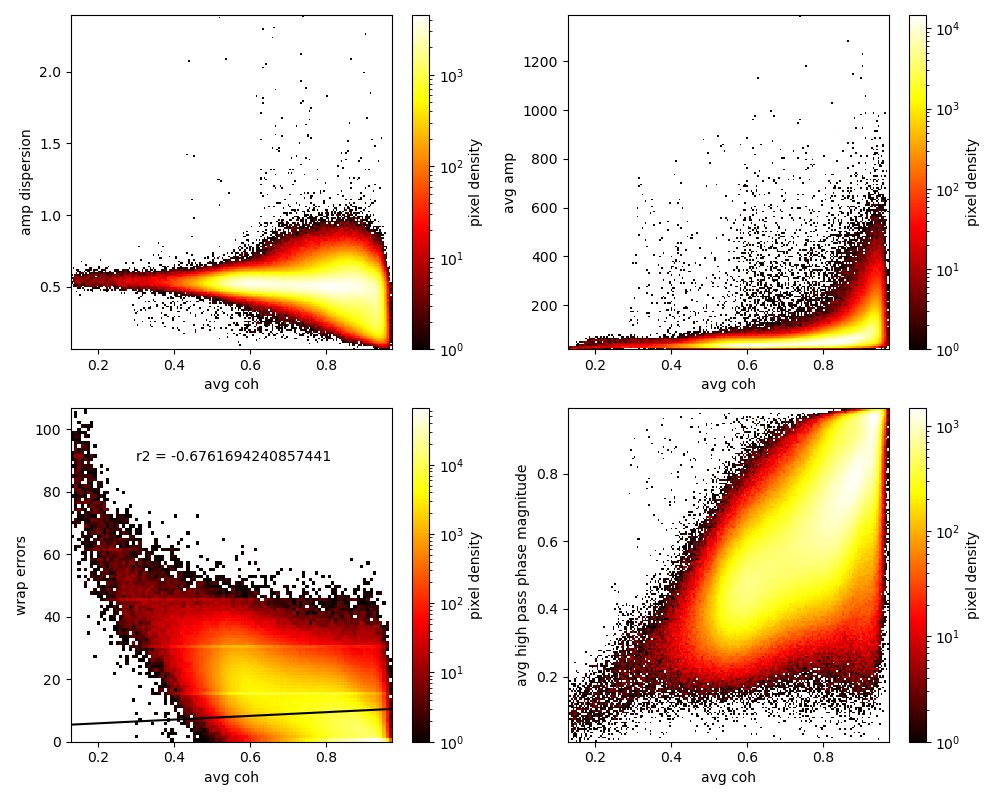

In [4]:
import matplotlib.colors as mcolors
numBins = 200

plt.figure(figsize=(10,8),tight_layout=True)
plt.subplot(2,2,1)
plt.hist2d(coh_avg.flatten(),amp_dispersion.flatten(),bins=numBins,norm=mcolors.LogNorm())
plt.colorbar(label='pixel density'); plt.set_cmap('hot') # plasma is original 
plt.xlabel('avg coh'); plt.ylabel('amp dispersion')
plt.subplot(2,2,2)
plt.hist2d(coh_avg.flatten(),avg_amp.flatten(),bins=numBins,norm=mcolors.LogNorm())
plt.colorbar(label='pixel density'); plt.set_cmap('hot') # plasma is original 
plt.xlabel('avg coh'); plt.ylabel('avg amp')
plt.subplot(2,2,3)
plt.hist2d(coh_avg.flatten(),wrap_err.flatten(),bins=100,norm=mcolors.LogNorm())
plt.colorbar(label='pixel density'); plt.set_cmap('hot') # plasma is original 
plt.xlabel('avg coh'); plt.ylabel('wrap errors')

m,b = np.polyfit(coh_avg.flatten(),wrap_err.flatten(),1)
x = [coh_avg.min(),coh_avg.max()]
y = [x[0]*m+b,x[1]*m+b]
all_y = m*coh_avg.flatten()+b
plt.plot(x,y,'k-')
r2 = np.corrcoef(wrap_err.flatten(),all_y)
plt.text(0.3,90,'r2 = '+str(r2[0,1]))

plt.subplot(2,2,4)
plt.hist2d(coh_avg.flatten(),hp_phs.flatten(),bins=numBins,norm=mcolors.LogNorm())
plt.colorbar(label='pixel density'); plt.set_cmap('hot') # plasma is original 
plt.xlabel('avg coh'); plt.ylabel('avg high pass phase magnitude')

plt.show()

Plot the metrics vs. each other with the third as the scatter colors. Do for different combos and see if any patterns emerge. This is for entire time interval of study, not individual time intervals. 

In [4]:
# this takes ~2 minutes
plt.figure(figsize=(10,8),tight_layout=True)
plt.subplot(2,2,1)
plt.scatter(hp_phs.flatten(),amp_dispersion.flatten(),c=wrap_err.flatten(),s=2)
plt.colorbar(label='wrap error'); plt.set_cmap('jet') 
plt.xlabel('hp phase'); plt.ylabel('amp dispersion')
plt.ylim([0,1.1])
plt.subplot(2,2,2)
plt.scatter(wrap_err.flatten(),hp_phs.flatten(),c=amp_dispersion.flatten(),s=2,vmin=0.2,vmax=0.6)
plt.colorbar(label='amp dispersion'); plt.set_cmap('jet') 
plt.xlabel('wrap error'); plt.ylabel('hp phase')
plt.subplot(2,2,3)
plt.scatter(amp_dispersion.flatten(),wrap_err.flatten(),c=hp_phs.flatten(),s=2)
plt.colorbar(label='hp phase'); plt.set_cmap('jet') 
plt.xlabel('amp dispersion'); plt.ylabel('wrap error')
plt.xlim([0,1.1])
plt.show()

KeyboardInterrupt: 

Load a disp rate map. 

In [ ]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
# dx = 3000
# dy = 750
# larger cropped area with western mountains 
dx = 4000
dy = 1100
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
#driver=gdal.GetDriverByName('ISCE')
start_indices = [0,47,108,147,0,0,107]
end_indices = [46,107,146,numIgrams,88,numIgrams,153] # the last one I just added (4-12-23) as a totally dry period
num_intervals = len(end_indices)
# choose 'filt' or 'unfilt'
key1 = 'unfilt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'
# choose interval
j = 5; i = j
# read in disp rate file + rmse file
fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'
disp_rates = np.ndarray((dy,dx),dtype='float') 
f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None
print('interval '+str(j)+' disp rate map + errors loaded.')

interval 5 disp rate map + errors loaded.


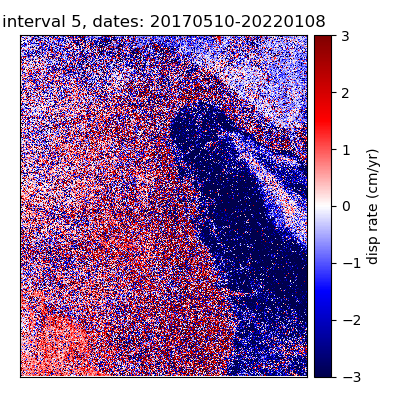

In [ ]:
i = j # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
plt.figure(figsize=(4,4),tight_layout=True)
plt.imshow(disp_rates, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

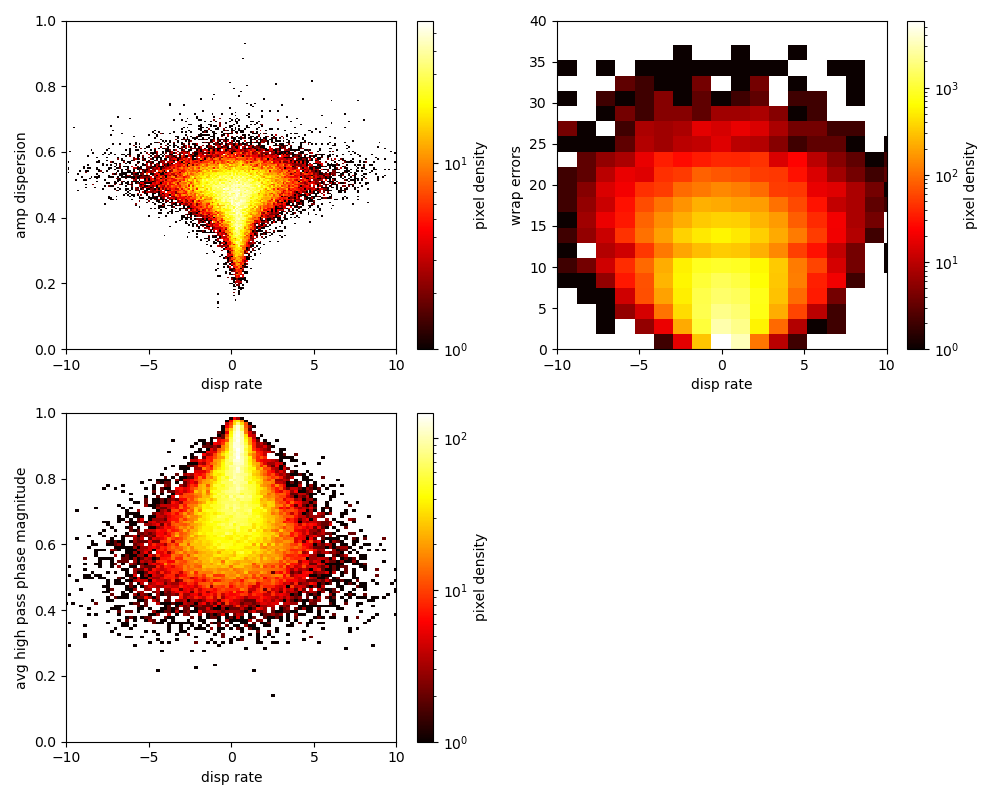

In [ ]:
box1x = [3000,3500];  box1dx = box1x[1]-box1x[0]
box1y = [300, 400];   box1dy = box1y[1]-box1y[0]

disp_rates_box = disp_rates[box1y[0]:box1y[1],box1x[0]:box1x[1]]
amp_disp_box = amp_dispersion[box1y[0]:box1y[1],box1x[0]:box1x[1]]
wrap_err_box = wrap_err[box1y[0]:box1y[1],box1x[0]:box1x[1]]
hp_phs_box = hp_phs[box1y[0]:box1y[1],box1x[0]:box1x[1]]

numBins = 200

plt.figure(figsize=(10,8),tight_layout=True)
plt.subplot(2,2,1)
plt.hist2d(disp_rates_box.flatten(),amp_disp_box.flatten(),bins=numBins,norm=mcolors.LogNorm())
plt.colorbar(label='pixel density'); plt.set_cmap('hot') # plasma is original 
plt.xlabel('disp rate'); plt.ylabel('amp dispersion')
plt.ylim([0,1]); plt.xlim([-10,10])
plt.subplot(2,2,2)
plt.hist2d(disp_rates_box.flatten(),wrap_err_box.flatten(),bins=20,norm=mcolors.LogNorm())
plt.colorbar(label='pixel density'); plt.set_cmap('hot') # plasma is original 
plt.xlabel('disp rate'); plt.ylabel('wrap errors')
plt.ylim([0,40]); plt.xlim([-10,10])
plt.subplot(2,2,3)
plt.hist2d(disp_rates_box.flatten(),hp_phs_box.flatten(),bins=100,norm=mcolors.LogNorm())
plt.colorbar(label='pixel density'); plt.set_cmap('hot') # plasma is original 
plt.xlabel('disp rate'); plt.ylabel('avg high pass phase magnitude')
plt.ylim([0,1]); plt.xlim([-10,10])
plt.show()